## Analysis 2
# Projection of visit 1 and visit 2
# visit 1,  individual + 17 LVs, cluster individuals at tp1 using 17LVs, can we recover 3 groups
# visit 2,  individual + 17 LVs, cluster individuals at tp1 using 17LVs, can we recover 3 groups
# visit 2-1,  individual + 17 LVs, cluster individuals at tp1 using 17LVs, can we recover 3 groups

#are the individuals that progressed to T1D different from LVs perspective
# Among LVs do we find pattern in beta cells, Islet of Languerhans, T-Lymphocytes 

# Modules and function 

In [3]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.spatial.distance import pdist
from sklearn import cluster
from sklearn.metrics import adjusted_rand_score as ari
from sklearn.metrics import (
    calinski_harabasz_score,
    davies_bouldin_score,
    silhouette_score,
)
from sklearn.metrics import normalized_mutual_info_score as nmi
import pyreadr

#function to flatten a list of list to a list
def flatten(xss):
    return [x for xs in xss for x in xs]

In [9]:
# Preparing data for Clustering

### Chosing time point and Importing RNA Dataset, and LVs of interest

In [10]:
# chose tp
# tp = "diff"
# tp = "2"
tp = "1"

# load dataset and convert into panda dataframe

filename = "output/gp_RNA_proj_" + tp + ".rds"
RNAseq_data = pyreadr.read_r(filename)
RNAseq_pd = RNAseq_data[None]

# import list of LVs to including in clustering algorithm and flatten
with open("T1D_17_LV.json") as f:
    list_list = json.load(f)
T1D_17_LV = flatten(list_list)
T1D_17_LV

# separate data into features and label 
data = RNAseq_pd.filter(items=T1D_17_LV)
data_labels = RNAseq_pd.pop("Group")

output/gp_RNA_proj_1.rds


### Check data dimension, and label groupping

In [21]:
print(data.shape)
print(data_labels.value_counts())
data.head()

(136, 17)
Group
Maintainer    64
Reverter      47
Progressor    25
Name: count, dtype: int64


LV844     LV913     LV205      LV71      LV45     LV342     LV572  \
0 -0.015536  0.045968 -0.047439 -0.001270 -0.059468 -0.011166  0.000582   
1  0.025954 -0.010176  0.021556  0.025651  0.053907 -0.011870 -0.020931   
2  0.029461 -0.007397  0.019991  0.042160  0.022355  0.000823 -0.018638   
3  0.017905 -0.040487  0.040945 -0.022055  0.041616  0.000240 -0.034372   
4 -0.038197 -0.046642 -0.018090  0.012616 -0.035503  0.014578 -0.010394   

      LV293     LV987     LV109     LV906      LV54     LV625     LV187  \
0  0.025370 -0.018575  0.014328 -0.050262 -0.039476 -0.005958 -0.052297   
1  0.039572  0.040909  0.046024 -0.016910  0.044702 -0.004870 -0.009036   
2  0.016615  0.022870  0.020537  0.035271  0.004461 -0.044798 -0.062135   
3 -0.026464  0.036236  0.017157  0.013463  0.002944  0.017137 -0.017826   
4  0.019111 -0.022639 -0.034770  0.009179  0.005353 -0.012032 -0.000075   

       LV52     LV861     LV835  
0  0.012859 -0.040480 -0.024745  
1 -0.002944  0.010597 -0.066321  
2 -0.042052 -0.053286 -0.041293  
3  0.014269  0.051384 -0.032674  
4 -0.017295 -0.014678  0.046195

# Look at stable clusters in the data

Text(0, 0.5, 'Stability Score')

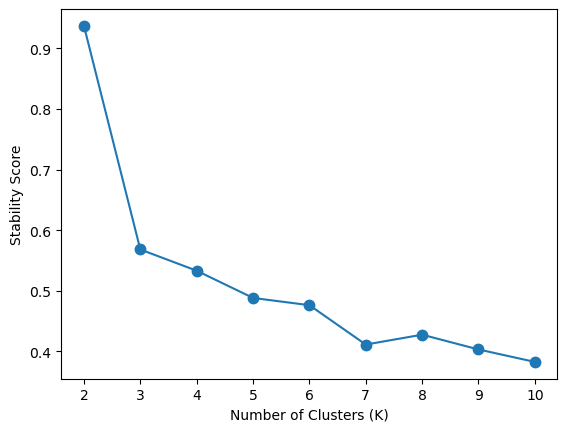

In [122]:
# Convert data into array
X = data.to_numpy()

# set seed for randomness
np.random.seed(0)

# number of clusters to test for stability  (2 to 10)
Ks = range(2, 11)

# repeat test 10 times for each number of cluster K
n_reps = 10
cluster_labels = []
pairwise_ari = []
centroid_positions = {}
stability_scores = []

for k in Ks:
    labels = []
    # mean of all data points assigned to each cluster
    centroids = []
    # Repeat steps below 10(n_reps) times for cluster k (eg = 2)
    for _ in range(n_reps):
        # create an instance of Kmeans clustering where data will be divided into k (eg: 2) clusters with initial placement of each cluster center (centroids) being automatic
        model = cluster.KMeans(n_clusters=k, n_init="auto")
        # predict which cluster each data point belongs to based on model above, save labels in empty list "labels" 
        labels.append(model.fit_predict(X))
        # calculate mean of all the data points in each cluster after being assigned
        centroids.append(model.cluster_centers_)
    #At the end of for-loop for k (eg: 2):
        # label has 10 elements,  each element in label has n values (136), each n is either 1 or 2 indicating which cluster each datapoint would belong to
        # centroids has 10 elements, each element has k elements (eg:  2 values: mu1 and mu2 for k=2),  which is the centroid (mean value of all points belong to respective cluster eg: 1 and 2), each mean point has 17 dimensions because 17 features were used) 

    # save the label arrays from the 10 iteration  of size n (136) each for each cluster k
    # cluster_labels contains leng(k) (10) elements, each element contains 1 element containing n (sample = 136) datapoint. 
    cluster_labels.append(labels)
    
    #save centroids from 10 iterations, of size k each for each cluster k, each k has size d (dimension = 17 LV)
    # centroid_positions contains leng(k) (10) elements, each element contains k centroids for each cluster,each centroid has d dimensions (dimension = 17 LV) 
    centroid_positions[k] = centroids
    
    # Compute pairwise adjusted Rand index (ARI) for stability
    # if ari = 1 perfect match, 0 =  no better than random assignment, less than 0 = two clustering are worse than random assignment
    # computes pairwise distance between the 10 arrays (size 136 each): 
    # ARI: There are 45 possible pairs. ARI (-1,1)  computes similarity of each 45 pair of vector, taking into account that some pairwise agreements could be due to chance.  
    ari_distances = pdist(labels, metric=ari)
    #  ari_distance: 1-ARI 
    # If 0: iteration pair is very similar, cluster is very stable 
    # If 1:  iteration pair is as different as you would expected if it was random
    # If >1: iteration pair is more different than you would expect by chance

    #for each k, save the distances (size 45) in pairwise_ari (10, 45)
    pairwise_ari.append(ari_distances)

    #for each k, compute stability score which is the average of the 45 distances. (10,1)
    stability_scores.append(ari_distances.mean())

plt.plot(Ks, stability_scores, marker=".", linestyle="-", markersize=15)
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Stability Score")

In [125]:
# Use ari and nmi to compare eack k clusters to ground truth, do we see a value of k at which the two agree? 
# ari looks at the amount of similarity adjusted by chance between the two vectors of cluster assignment
perf_ari = {}

# nmi looks at the amount of shared information between two clustering, adjusted for number of clusters between the two. Which would work better when comparing ground truth (k = 3) to any vector with k != 3
perf_nmi = {}

# compare clustering from 2-10 to ground truth using ari and nmi, save data in _tmp
for k in Ks:
    model = cluster.KMeans(n_clusters=k, n_init="auto")
    part = model.fit_predict(X)
    perf_ari[k] = ari(part, data_labels)
    perf_nmi[k] = nmi(part, data_labels)

# if 0 = ari:cluster no better than random; nmi: no shared information
# if 1 =  ari: perfect agreement between clusterings; nmi: clustering identical
_tmp = pd.DataFrame(
    {
        "ari": perf_ari,
        "nmi": perf_nmi,
    },
    index=Ks,
)
display(_tmp)

In [128]:
# do the metrics agree? yes they slightly agree that the clustering is not useful
_tmp.corr()

ari       nmi
ari  1.000000  0.476766
nmi  0.476766  1.000000

## Question 4

Use at least two internal metrics to measure the quality of the clustering solutions.

1. Do they match with the agreement with the true labels? Why?
2. Do they match among them?

In [130]:
perf_s = {}
perf_c = {}
perf_d = {}
for k in Ks:
    model = cluster.KMeans(n_clusters=k, n_init="auto")
    part = model.fit_predict(X)
    perf_s[k] = silhouette_score(X, part)
    perf_c[k] = calinski_harabasz_score(X, part)
    perf_d[k] = davies_bouldin_score(X, part)

In [131]:
_tmp = pd.DataFrame(
    {
        "Silhouette": perf_s,
        "CH": perf_c,
        "DB": perf_d,
    },
    index=Ks,
)
display(_tmp)

Silhouette         CH        DB
2     0.227472  40.691698  1.613420
3     0.121986  27.928135  1.922343
4     0.157113  22.108559  1.680701
5     0.099472  21.673303  2.049361
6     0.074588  18.974141  2.149854
7     0.098680  17.331883  1.853100
8     0.059618  14.894805  2.200968
9     0.089352  15.283162  1.798531
10    0.056869  13.846776  2.097489

In [132]:
_tmp.corr()

Silhouette        CH        DB
Silhouette    1.000000  0.916184 -0.850881
CH            0.916184  1.000000 -0.616973
DB           -0.850881 -0.616973  1.000000

_Answer_: add answer

_Answer_:
1. Yes, in general, especially for Silhouette (max value/best for $K=4$) and DB (min value/best for $K=4$). CH has the max/best value for $K=2$ and then $K=4$.
2. Yes, in general, they match well.

## Question 5

Explore the different features of the dataset and find the top 2 ones that are most helpful to capture the true labels in the data. Answer the following questions:

1. What are the most important features that the algorithm used to accurately cluster the data? Are some features more important than others?
1. How did you explore the set of features to pick the best ones?
1. Create a 2-dimensional plot using the two top features you found. Include the true labels and centroids learned by $K$-Means using the $K$ with the most accurate solution.
1. Related to the second question: think about some approaches that could be used to automatically learn the most important features that are driving clustering results.

In [134]:
data

LV844     LV913     LV205      LV71      LV45     LV342     LV572  \
0   -0.015536  0.045968 -0.047439 -0.001270 -0.059468 -0.011166  0.000582   
1    0.025954 -0.010176  0.021556  0.025651  0.053907 -0.011870 -0.020931   
2    0.029461 -0.007397  0.019991  0.042160  0.022355  0.000823 -0.018638   
3    0.017905 -0.040487  0.040945 -0.022055  0.041616  0.000240 -0.034372   
4   -0.038197 -0.046642 -0.018090  0.012616 -0.035503  0.014578 -0.010394   
..        ...       ...       ...       ...       ...       ...       ...   
131  0.007297 -0.002463  0.012370  0.041416  0.041807  0.007587  0.011451   
132  0.076063  0.061056 -0.003460  0.020725  0.015058 -0.041471  0.000630   
133 -0.019214  0.009525  0.003726 -0.010683 -0.000092 -0.003390 -0.051439   
134 -0.066061 -0.011429 -0.018790  0.002902 -0.017608 -0.017632 -0.008982   
135  0.056239  0.041890  0.039736  0.051235  0.045815  0.019434  0.019233   

        LV293     LV987     LV109     LV906      LV54     LV625     LV187  \
0    0.025370 -0.018575  0.014328 -0.050262 -0.039476 -0.005958 -0.052297   
1    0.039572  0.040909  0.046024 -0.016910  0.044702 -0.004870 -0.009036   
2    0.016615  0.022870  0.020537  0.035271  0.004461 -0.044798 -0.062135   
3   -0.026464  0.036236  0.017157  0.013463  0.002944  0.017137 -0.017826   
4    0.019111 -0.022639 -0.034770  0.009179  0.005353 -0.012032 -0.000075   
..        ...       ...       ...       ...       ...       ...       ...   
131  0.025984 -0.004604 -0.011602  0.015333  0.024328 -0.002266 -0.036639   
132  0.016063  0.031106  0.033530 -0.017113 -0.004523 -0.035478 -0.024924   
133  0.030573  0.031233 -0.025988 -0.027225  0.018070 -0.019094 -0.024015   
134  0.010202  0.039198 -0.041007 -0.012026 -0.008970 -0.030739  0.025979   
135  0.034995  0.105531 -0.023598  0.069323 -0.008744  0.000344  0.024333   

         LV52     LV861     LV835  
0    0.012859 -0.040480 -0.024745  
1   -0.002944  0.010597 -0.066321  
2   -0.042052 -0.053286 -0.041293  
3    0.014269  0.051384 -0.032674  
4   -0.017295 -0.014678  0.046195  
..        ...       ...       ...  
131  0.027544  0.031048 -0.010434  
132  0.024825 -0.066582 -0.040634  
133 -0.005916 -0.021999  0.074922  
134 -0.029772 -0.035937  0.009829  
135  0.000193  0.036186  0.057829  

[136 rows x 17 columns]

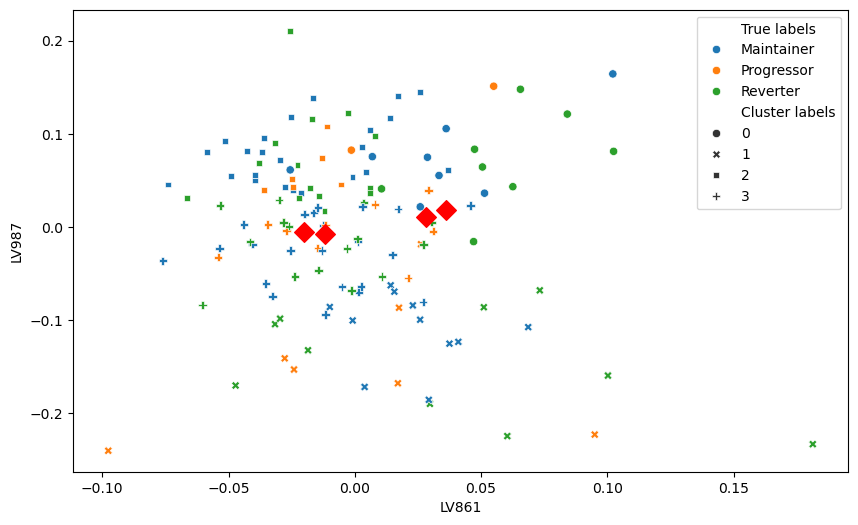

In [138]:
fig, ax = plt.subplots(figsize=(10, 6))

model = cluster.KMeans(n_clusters=4, n_init=10)
part = model.fit_predict(X)

true_labels = pd.Series(data_labels).astype("category").rename("True labels")
cluster_labels = pd.Series(part).astype("category").rename("Cluster labels")

ax = sns.scatterplot(
    data,
    x="LV861",
    y="LV987",
    hue=true_labels,
    style=cluster_labels,
)

ax.scatter(
    model.cluster_centers_[:, 0],
    model.cluster_centers_[:, 1],
    marker="D",
    color="red",
    s=100,
)

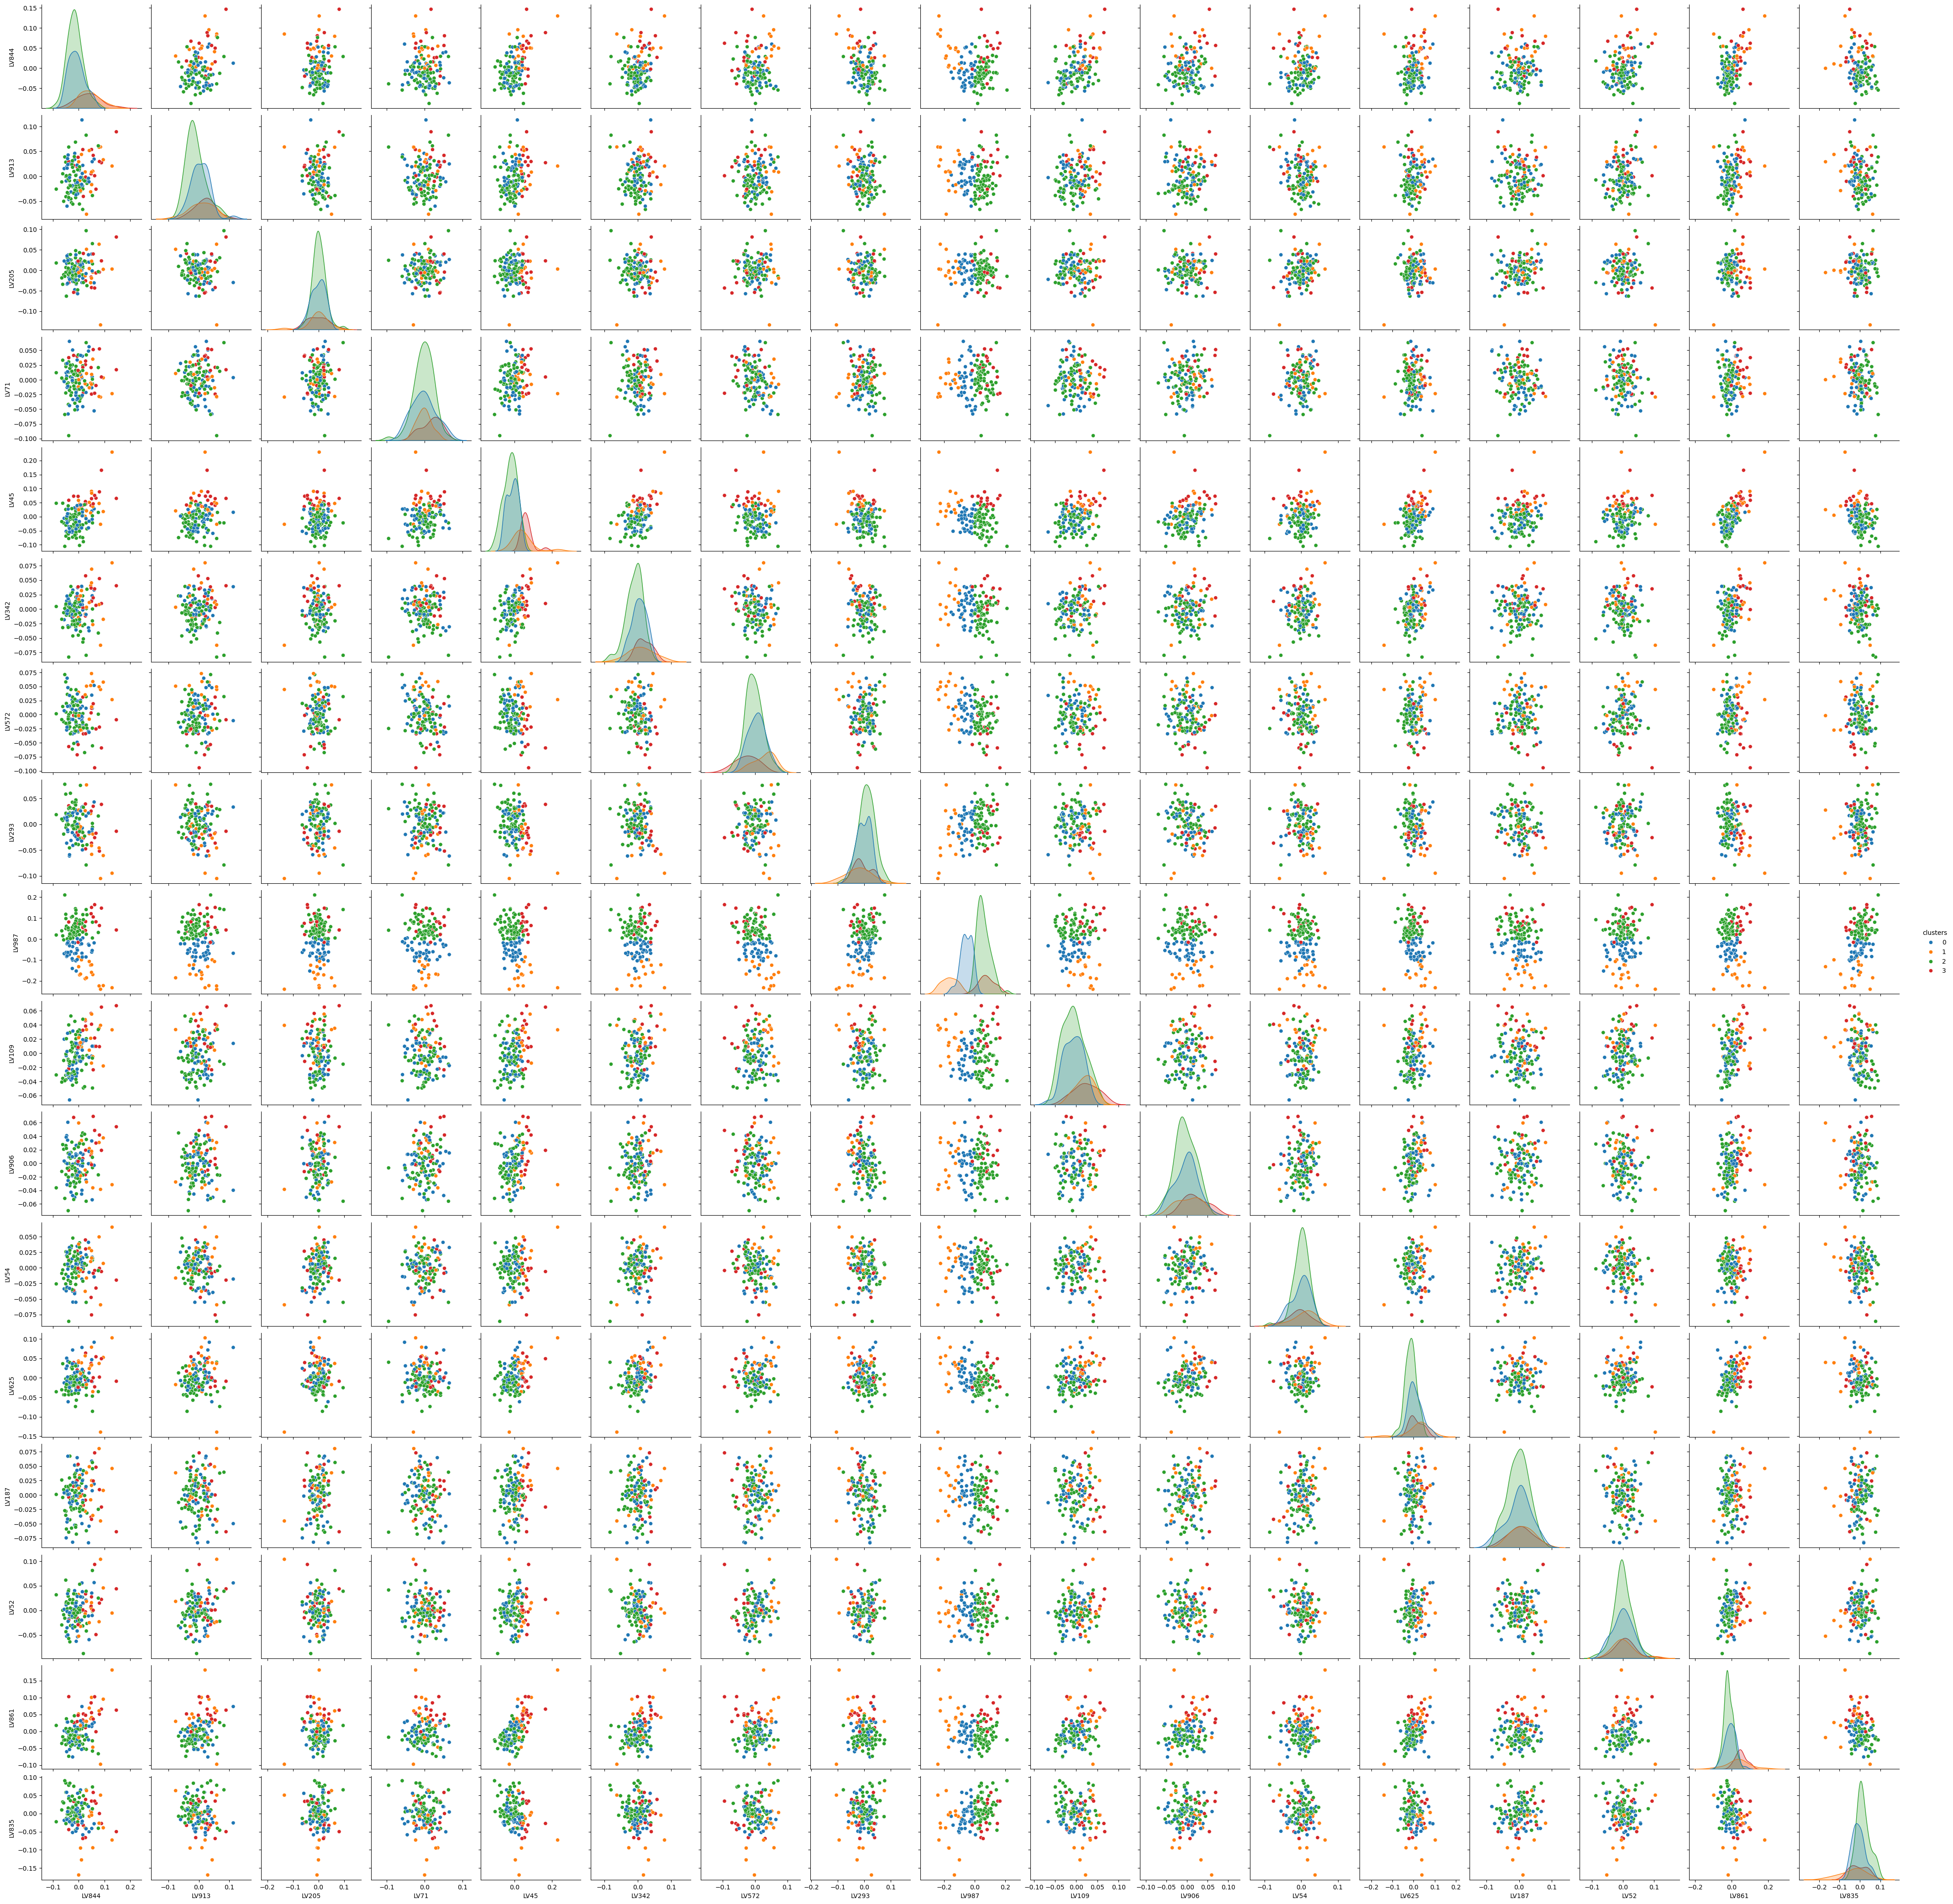

In [137]:
sns.pairplot(data.assign(clusters=cluster_labels), hue="clusters")

_Answer_: add answer

_Answer_:
1. The first two features are the most important (I'm cheating here, because I already know this dataset :))
2. Since this is a simple and small dataset, a naive approach is to take pairs of features and plot the data (for example, using [`seaborn.pairplot`](https://seaborn.pydata.org/generated/seaborn.pairplot.html) as above) to see which ones align better with the cluster solutions and centers. However, this takes time, it's subjective, and is infeasible on large datasets.
3. Done above.
4. Other approaches to find the most important features:
   1. Another approach could be to use internal metrics using pairs of features and pick the pair that produces the best metric value.
   1. A more advanced approach consists of using interpretable classifiers trained on labels generated by the clustering algorithm. For example, classifiers such as Decision Trees produce an easy-to-interpret tree with features that separate the labels. The approach is described [here](https://insidelearningmachines.com/decision_trees_for_clustering/) (you can omit the splitting of training and test sets, as we'll learn that later in the course). An implementation is shown below.

### Using a Decision Tree classifier to interpret clustering results

In [139]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [140]:
X.shape

(136, 17)

In [141]:
model = cluster.KMeans(n_clusters=3, n_init=10, random_state=0)
part = model.fit_predict(X)

clt = DecisionTreeClassifier(max_depth=3, random_state=0).fit(X, part)

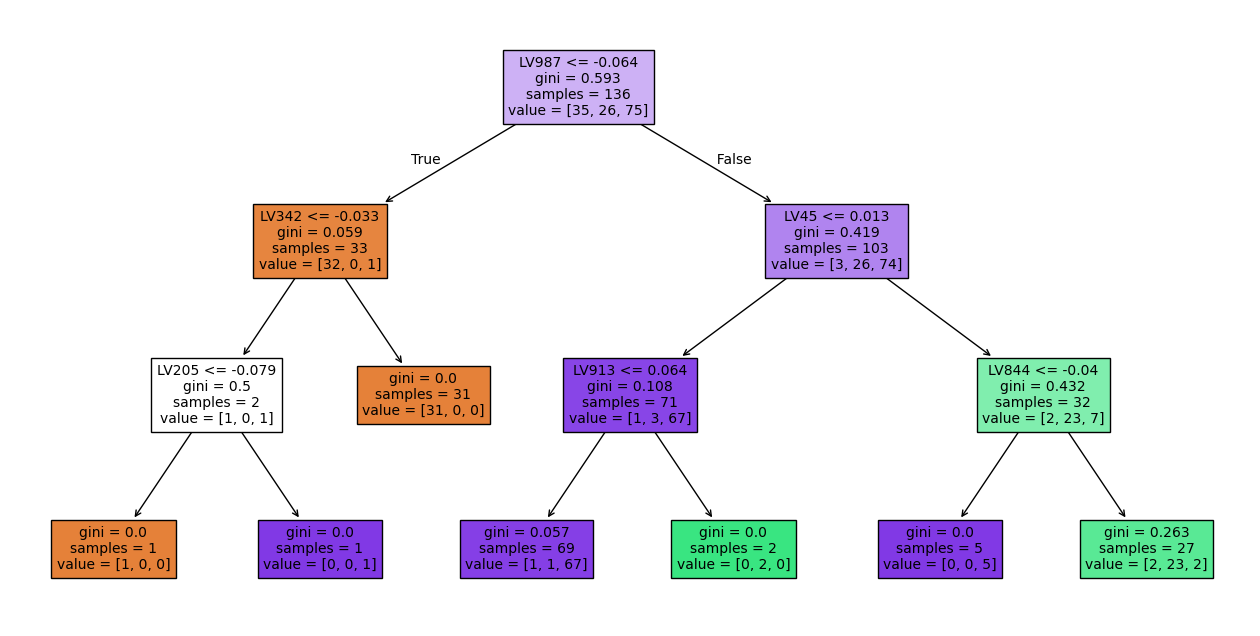

In [142]:
fig = plt.figure(figsize=(16, 8))
_ = plot_tree(
    clt,
    filled=True,
    fontsize=10,
    feature_names=data.columns.tolist(),
)

It can be seen that the classifier is only using the first and second features to separate the labels found by $K$-Means.
In this example, we have the true labels, but in a more realistic application we won't have that, and this approach can be useful to interpret our clustering results.

Try to look at the plot of the data we created above and understand the rules that we extract using the tree plot. Does it make sense what the classifier is doing?

## Question 6

Let's assume that our dataset's objects are people and its features include measurements such as height (in meters, with values such as `1.55` or `1.95`) and year of birth (such as `1945` or `2001`). Clearly, these two features have different scales. Let's simulate that in our dataset:

In [143]:
# let's see what are the stats across features in the original data
data.describe()

LV844         LV913         LV205          LV71          LV45  \
count  1.360000e+02  1.360000e+02  1.360000e+02  1.360000e+02  1.360000e+02   
mean   5.000085e-18 -1.938809e-18 -4.285787e-18 -1.428596e-18 -3.061277e-18   
std    4.039405e-02  3.370529e-02  3.006239e-02  2.767991e-02  4.846061e-02   
min   -8.758624e-02 -7.617793e-02 -1.333703e-01 -9.490982e-02 -1.056810e-01   
25%   -2.861300e-02 -2.341280e-02 -1.826535e-02 -1.766897e-02 -3.188185e-02   
50%   -6.628831e-03 -4.136044e-03  3.853626e-04 -7.316296e-04 -7.718368e-04   
75%    1.917693e-02  2.262367e-02  1.961601e-02  1.646265e-02  2.776827e-02   
max    1.462367e-01  1.129733e-01  9.655868e-02  6.518950e-02  2.299439e-01   

              LV342       LV572         LV293       LV987         LV109  \
count  1.360000e+02  136.000000  1.360000e+02  136.000000  1.360000e+02   
mean   1.224511e-18    0.000000  3.163319e-18    0.000000 -2.653106e-18   
std    2.715010e-02    0.031312  3.287944e-02    0.090631  2.730583e-02   
min   -8.293760e-02   -0.094671 -1.051358e-01   -0.240287 -6.629951e-02   
25%   -1.781111e-02   -0.022583 -1.915850e-02   -0.062981 -2.287529e-02   
50%    9.430236e-04    0.000092 -8.989470e-04    0.018222 -3.234263e-03   
75%    1.469597e-02    0.019803  2.201002e-02    0.061219  1.922028e-02   
max    7.990422e-02    0.072926  7.772638e-02    0.210685  6.723978e-02   

              LV906          LV54         LV625         LV187          LV52  \
count  1.360000e+02  1.360000e+02  1.360000e+02  1.360000e+02  1.360000e+02   
mean  -5.714383e-18 -3.265362e-18 -1.938809e-18  1.632681e-18  3.265362e-18   
std    2.779377e-02  2.554603e-02  3.495063e-02  3.441742e-02  3.092975e-02   
min   -7.000892e-02 -8.590954e-02 -1.392127e-01 -8.311043e-02 -8.784643e-02   
25%   -1.812543e-02 -1.418768e-02 -2.151827e-02 -2.322052e-02 -1.786923e-02   
50%   -5.132395e-04  2.475928e-03 -4.573985e-03  1.270233e-03 -1.012738e-03   
75%    1.765653e-02  1.679151e-02  2.333152e-02  2.222448e-02  1.733156e-02   
max    6.932343e-02  6.518202e-02  1.025679e-01  8.053910e-02  1.038154e-01   

              LV861         LV835  
count  1.360000e+02  1.360000e+02  
mean  -4.183745e-18  8.775660e-18  
std    4.098926e-02  4.061839e-02  
min   -9.764382e-02 -1.690555e-01  
25%   -2.716598e-02 -2.400748e-02  
50%   -4.100074e-03  2.044880e-04  
75%    2.583306e-02  2.521037e-02  
max    1.814037e-01  9.016341e-02

In [144]:
data_scaled = data.copy()

In [145]:
from sklearn.preprocessing import minmax_scale

In [24]:
# f6 will be height
data_scaled["f6"] = minmax_scale(data["f6"], feature_range=(1.2, 2.05))

# and f7 will be year of birth
data_scaled["f7"] = np.ceil(minmax_scale(data["f7"], feature_range=(1945, 2001)))

In [25]:
# let's verify the stats/ranges of our new features
data_scaled.describe()

f1          f2          f3          f4          f5          f6  \
count  100.000000  100.000000  100.000000  100.000000  100.000000  100.000000   
mean     1.426425    1.222585    2.122137    2.034657    2.047784    1.604827   
std      2.762913    3.476864    1.169307    1.143062    1.063029    0.253984   
min     -4.539012   -5.190981    0.073070    0.033522    0.070147    1.200000   
25%     -0.487561   -1.019238    1.166957    1.018976    1.270292    1.380180   
50%      1.183115    0.806465    2.049049    2.021329    2.055746    1.606009   
75%      3.929524    4.200504    3.139445    3.056537    2.837758    1.793315   
max      6.508632    6.873952    3.968635    3.980859    3.954391    2.050000   

                f7          f8          f9         f10         f11         f12  
count   100.000000  100.000000  100.000000  100.000000  100.000000  100.000000  
mean   1971.710000    1.972853    2.160616    1.802824    1.945195    2.067451  
std      16.010284    1.161838    1.157607    1.147469    1.174753    1.174859  
min    1945.000000    0.049635    0.014697    0.088058    0.023665    0.017672  
25%    1956.750000    0.892831    1.247181    0.764301    0.825872    1.193729  
50%    1973.000000    2.149544    2.183210    1.701763    1.962398    2.139220  
75%    1984.000000    2.915272    3.147419    2.835454    2.944727    3.221551  
max    2001.000000    3.981973    3.979669    3.899856    3.958024    3.975148

It can be seen that the mean, standard deviation, minimum, and maximum values are very different now when we compare the features.

1. How does our clustering approach perform in this new dataset?
2. Why is this happening? How can we fix it? *Tip:* take a look at the [preprocessing functions in sklearn](https://scikit-learn.org/1.5/modules/preprocessing.html). Try the [StandardScaler](https://scikit-learn.org/1.5/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler).

_Answer_: add answer

### Performance on new dataset

Text(0, 0.5, 'Stability Score')

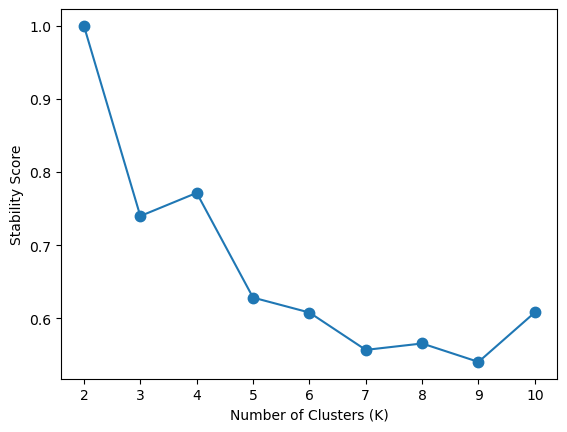

In [26]:
# cluster stability
X = data_scaled.to_numpy()

np.random.seed(0)

Ks = range(2, 11)
n_reps = 10
cluster_labels = []
pairwise_ari = []
centroid_positions = {}
stability_scores = []

for k in Ks:
    labels = []
    centroids = []

    for _ in range(n_reps):
        model = cluster.KMeans(n_clusters=k, n_init="auto")
        labels.append(model.fit_predict(X))
        centroids.append(model.cluster_centers_)

    cluster_labels.append(labels)
    centroid_positions[k] = centroids

    # Compute pairwise adjusted Rand index (ARI) for stability
    ari_distances = pdist(labels, metric=ari)
    pairwise_ari.append(ari_distances)
    stability_scores.append(ari_distances.mean())

plt.plot(Ks, stability_scores, marker=".", linestyle="-", markersize=15)
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Stability Score")

In [27]:
# comparison with true labels
perf_ari = {}
perf_nmi = {}
for k in Ks:
    model = cluster.KMeans(n_clusters=k, n_init="auto")
    part = model.fit_predict(X)
    perf_ari[k] = ari(part, data_labels)
    perf_nmi[k] = nmi(part, data_labels)

In [28]:
_tmp = pd.DataFrame(
    {
        "ari": perf_ari,
        "nmi": perf_nmi,
    },
    index=Ks,
)
display(_tmp)

ari       nmi
2   0.006349  0.020843
3  -0.005339  0.019436
4   0.027363  0.080635
5   0.000423  0.048116
6   0.051521  0.156834
7   0.041515  0.152928
8   0.057742  0.184822
9   0.097146  0.249201
10  0.093758  0.278826

In [29]:
# extract most important features for clustering results
X = data_scaled.to_numpy()
display(X.shape)

(100, 12)

In [30]:
model = cluster.KMeans(n_clusters=4, n_init=10, random_state=0)
part = model.fit_predict(X)

clt = DecisionTreeClassifier(max_depth=3, random_state=0).fit(X, part)

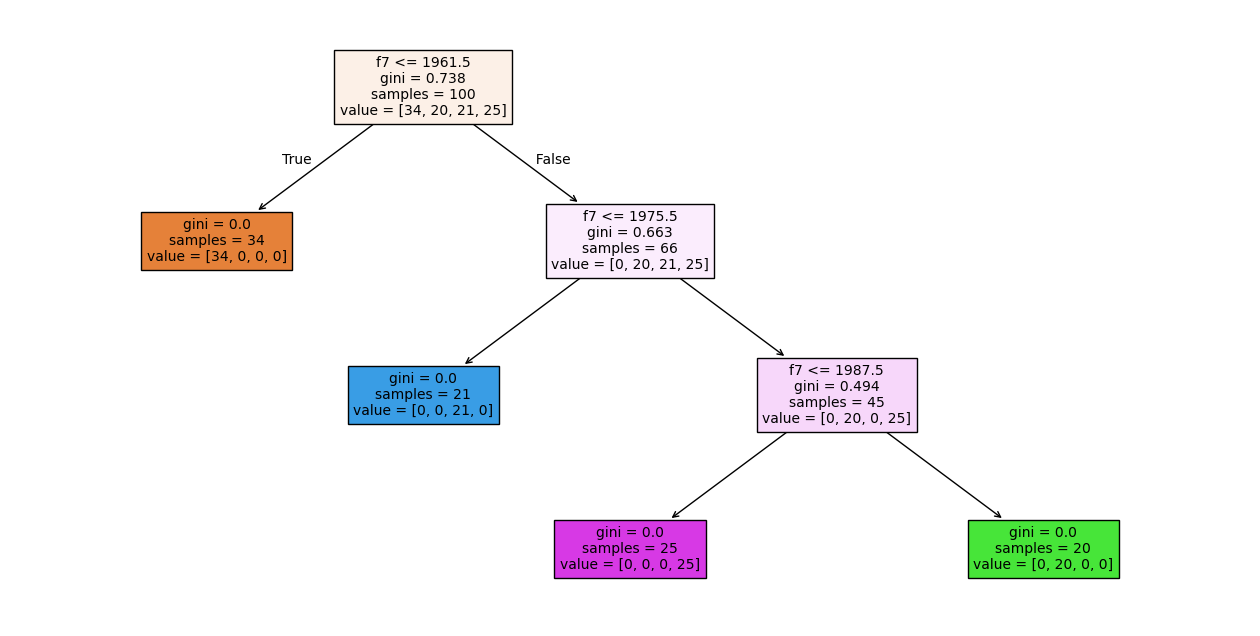

In [31]:
fig = plt.figure(figsize=(16, 8))
_ = plot_tree(clt, filled=True, fontsize=10, feature_names=data_scaled.columns.tolist())

_Answer_:
1. It performs worse! The stability of results is different, and now we don't capture the true labels.
2. This happens because there are two features with different scalings and this dominates the objective function of the algorithm. It's necessary to have all features on the same scale so no one dominates the rest.

**IMPORTANT:** Feature scaling is important! Even though we scaled the original features by preserving the order, the results are completely different. $K$-Means, given its objective function, is completely dominated by the feature with the largest variance.

### Let's properly standardize our data

In [32]:
from sklearn.preprocessing import StandardScaler

In [33]:
data_scaled.describe()

f1          f2          f3          f4          f5          f6  \
count  100.000000  100.000000  100.000000  100.000000  100.000000  100.000000   
mean     1.426425    1.222585    2.122137    2.034657    2.047784    1.604827   
std      2.762913    3.476864    1.169307    1.143062    1.063029    0.253984   
min     -4.539012   -5.190981    0.073070    0.033522    0.070147    1.200000   
25%     -0.487561   -1.019238    1.166957    1.018976    1.270292    1.380180   
50%      1.183115    0.806465    2.049049    2.021329    2.055746    1.606009   
75%      3.929524    4.200504    3.139445    3.056537    2.837758    1.793315   
max      6.508632    6.873952    3.968635    3.980859    3.954391    2.050000   

                f7          f8          f9         f10         f11         f12  
count   100.000000  100.000000  100.000000  100.000000  100.000000  100.000000  
mean   1971.710000    1.972853    2.160616    1.802824    1.945195    2.067451  
std      16.010284    1.161838    1.157607    1.147469    1.174753    1.174859  
min    1945.000000    0.049635    0.014697    0.088058    0.023665    0.017672  
25%    1956.750000    0.892831    1.247181    0.764301    0.825872    1.193729  
50%    1973.000000    2.149544    2.183210    1.701763    1.962398    2.139220  
75%    1984.000000    2.915272    3.147419    2.835454    2.944727    3.221551  
max    2001.000000    3.981973    3.979669    3.899856    3.958024    3.975148

In [34]:
scaler = StandardScaler().set_output(transform="pandas")
data_std = scaler.fit_transform(data_scaled)
display(data_std.describe())

f1            f2            f3            f4            f5  \
count  1.000000e+02  1.000000e+02  1.000000e+02  1.000000e+02  1.000000e+02   
mean   5.995204e-17 -4.662937e-17  7.771561e-17  9.436896e-17 -5.523360e-17   
std    1.005038e+00  1.005038e+00  1.005038e+00  1.005038e+00  1.005038e+00   
min   -2.169989e+00 -1.853934e+00 -1.761206e+00 -1.759499e+00 -1.869752e+00   
25%   -6.962319e-01 -6.480314e-01 -8.209922e-01 -8.930380e-01 -7.350773e-01   
50%   -8.850639e-02 -1.202856e-01 -6.281993e-02 -1.171872e-02  7.528283e-03   
75%    9.105279e-01  8.608104e-01  8.743926e-01  8.984885e-01  7.468796e-01   
max    1.848705e+00  1.633609e+00  1.587094e+00  1.711199e+00  1.802597e+00   

                 f6            f7            f8            f9           f10  \
count  1.000000e+02  1.000000e+02  1.000000e+02  1.000000e+02  1.000000e+02   
mean   6.172840e-16 -2.291500e-15  3.885781e-17  4.096723e-16  2.087219e-16   
std    1.005038e+00  1.005038e+00  1.005038e+00  1.005038e+00  1.005038e+00   
min   -1.601938e+00 -1.676707e+00 -1.663664e+00 -1.863093e+00 -1.501918e+00   
25%   -8.889472e-01 -9.391067e-01 -9.342637e-01 -7.930473e-01 -9.096154e-01   
50%    4.678836e-03  8.097912e-02  1.528449e-01  1.961611e-02 -8.851624e-02   
75%    7.458659e-01  7.714988e-01  8.152320e-01  8.567448e-01  9.044543e-01   
max    1.761590e+00  1.838666e+00  1.737972e+00  1.579306e+00  1.836735e+00   

                f11           f12  
count  1.000000e+02  1.000000e+02  
mean   5.995204e-17 -2.237099e-16  
std    1.005038e+00  1.005038e+00  
min   -1.643928e+00 -1.753491e+00  
25%   -9.576153e-01 -7.474284e-01  
50%    1.471766e-02  6.139521e-02  
75%    8.551309e-01  9.872802e-01  
max    1.722038e+00  1.631948e+00

Now our data is standardized: it has mean zero and standard deviation of one across all features.

Text(0, 0.5, 'Stability Score')

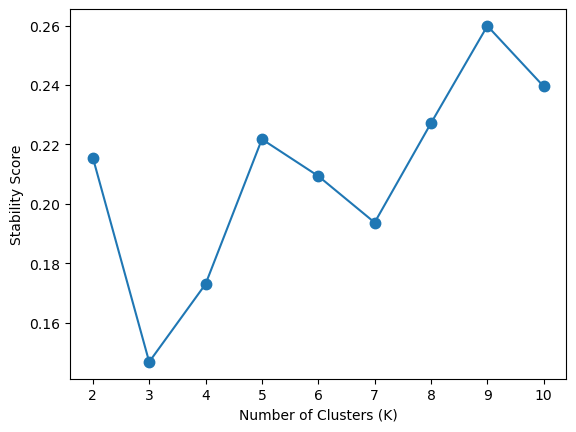

In [35]:
X = data_std.to_numpy()

np.random.seed(0)

Ks = range(2, 11)
n_reps = 10
cluster_labels = []
pairwise_ari = []
centroid_positions = {}
stability_scores = []

for k in Ks:
    labels = []
    centroids = []

    for _ in range(n_reps):
        model = cluster.KMeans(n_clusters=k, n_init="auto")
        labels.append(model.fit_predict(X))
        centroids.append(model.cluster_centers_)

    cluster_labels.append(labels)
    centroid_positions[k] = centroids

    # Compute pairwise adjusted Rand index (ARI) for stability
    ari_distances = pdist(labels, metric=ari)
    pairwise_ari.append(ari_distances)
    stability_scores.append(ari_distances.mean())

plt.plot(Ks, stability_scores, marker=".", linestyle="-", markersize=15)
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Stability Score")

In [36]:
perf_ari = {}
perf_nmi = {}
for k in Ks:
    model = cluster.KMeans(n_clusters=k, n_init="auto")
    part = model.fit_predict(X)
    perf_ari[k] = ari(part, data_labels)
    perf_nmi[k] = nmi(part, data_labels)

In [37]:
_tmp = pd.DataFrame(
    {
        "ari": perf_ari,
        "nmi": perf_nmi,
    },
    index=Ks,
)
display(_tmp)

ari       nmi
2   0.080425  0.097847
3   0.017817  0.050416
4   0.081736  0.187158
5   0.054053  0.138175
6   0.017897  0.072358
7   0.114198  0.201889
8   0.121585  0.278294
9   0.125960  0.294686
10  0.152577  0.299095

In [38]:
# X = data_scaled.to_numpy()
display(X.shape)

(100, 12)

In [39]:
model = cluster.KMeans(n_clusters=4, n_init=10, random_state=0)
part = model.fit_predict(X)

clt = DecisionTreeClassifier(max_depth=3, random_state=0).fit(X, part)

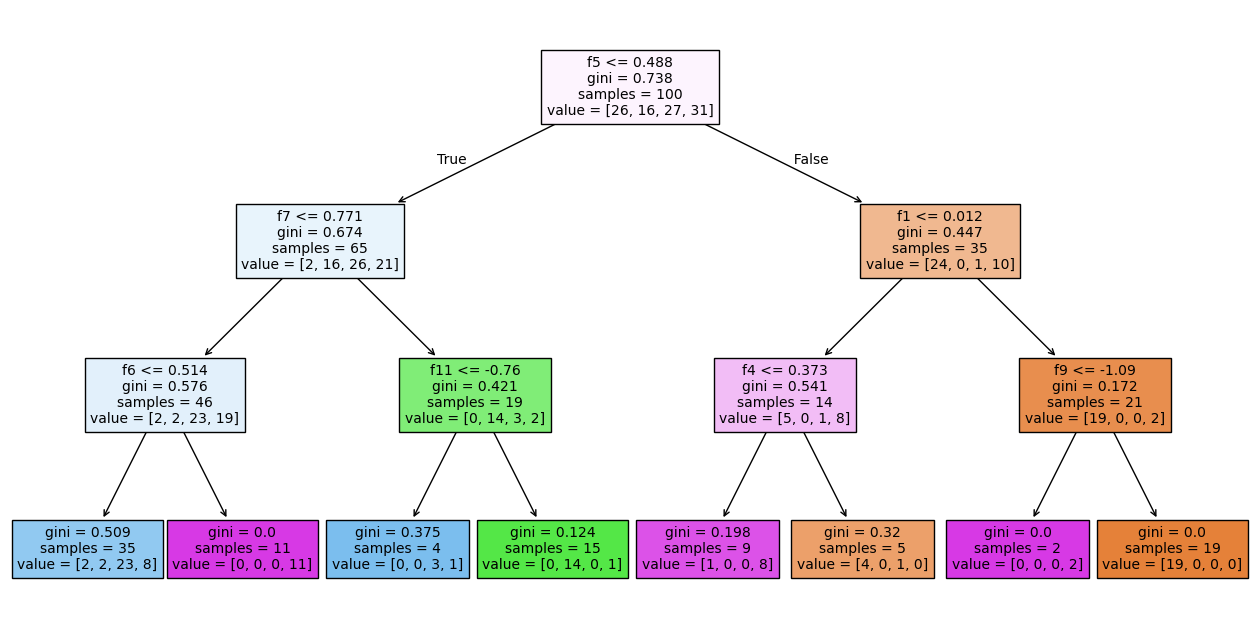

In [40]:
fig = plt.figure(figsize=(16, 8))
_ = plot_tree(clt, filled=True, fontsize=10, feature_names=data_scaled.columns.tolist())

Although standardizing the data is important and must be done in any cluster analysis on real data, the procedure transforms/changes the input data and the consequences are not always clear. In this artificially generated dataset, the two most important features are the first two ones, which have different scaling than the rest. The other 10 features are random noise. After scaling, the algorithm is no longer able to capture the true labels.

# Spectral clustering

As you probably guessed after answering Question 5 and making the plot, this dataset has a weird structure: it has two concentric rings.
It was generated with function [`make_circles`](https://scikit-learn.org/dev/modules/generated/sklearn.datasets.make_circles.html) from sklearn.
These complex datasets are used to test different clustering and classification algorithms with different degrees of difficulty.

So here you have the **first question**:
1. $K$-Means cannot capture this structure. Why not?

Now, let's try to answer Questions 3-5 but using different clustering algorithms and explore different parameters.
Some suggestions are:
* [Spectral Clustering](https://scikit-learn.org/1.5/modules/clustering.html#spectral-clustering):
  * It computes a low-dimensional embedding of the input data where the complex data structures (such as the rings) are more apparent. Then it applies $K$-Means on this embedding.
  * A suggestion on how to run it:

    ```python
        cluster.SpectralClustering(
            n_clusters=k, affinity="nearest_neighbors", n_init=1
        )
    ```

    You can try different parameters such as `affinity` or `gamma`.
* [DBSCAN](https://scikit-learn.org/1.5/modules/clustering.html#dbscan):
  * This algorithm is very different from $K$-Means. It is not centroid-based, but density-based. Some analyses, such as Consensus Index, are not directly applicable here.
  * The most important parameter is `eps`: make sure you use values around `0.30` for this dataset. One way to generate values in an interval is to use `np.linspace(0.20, 0.50, 100)`
  * A suggestion on how to run it:

    ```python
        model = cluster.DBSCAN(eps=k)
    ```

* [Hierarchical clustering](https://scikit-learn.org/1.5/modules/clustering.html#hierarchical-clustering):
  * This is a classic algorithm, very popular.
  * In addition to returning a single, flat partition, hierarchical clustering can produce a hierarchy of partitions, where clusters are subsequently divided into smaller ones. This hierarchical structure might be very useful in particular problems where we expect this data structure.
  * The main parameter, in addition to the number of clusters, is the `linkage` criteria that determines how to merge clusters.

Then also answer these **other questions**:

2. Were you successful with a different clustering algorithm? Which one?
3. Why did the new algorithm work?

_Answer_: add answer

_Answer_:
1. $K$-Means cannot capture this structure because this algorithm can only capture hyperspherical clusters. Any cluster structure that deviates from this assumption cannot be captured by $K$-Means. Each algorithm has assumptions about the underlying data structure, and it is important to know this before the application. Check out [this example](https://scikit-learn.org/1.5/auto_examples/cluster/plot_kmeans_assumptions.html) where other limitations of $K$-Means are illustrated.

### Spectral Clustering

#### Question 3

Text(0, 0.5, 'Stability Score')

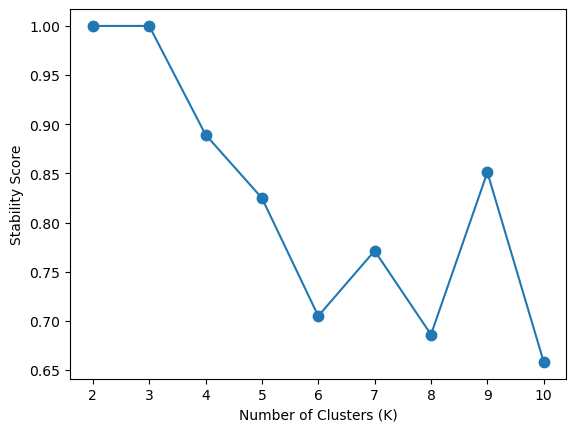

In [66]:
X = data.to_numpy()

np.random.seed(0)

Ks = range(2, 11)
n_reps = 10
cluster_labels = []
pairwise_ari = []
# centroid_positions = {}
stability_scores = []

for k in Ks:
    labels = []
    centroids = []

    for _ in range(n_reps):
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding"
                + " may not work as expected.",
                category=UserWarning,
            )
            model = cluster.SpectralClustering(
                n_clusters=k, affinity="nearest_neighbors", n_init=1
            )
            labels.append(model.fit_predict(X))
        # centroids.append(model.cluster_centers_)

    cluster_labels.append(labels)
    # centroid_positions[k] = centroids

    # Compute pairwise adjusted Rand index (ARI) for stability
    ari_distances = pdist(labels, metric=ari)
    pairwise_ari.append(ari_distances)
    stability_scores.append(ari_distances.mean())

plt.plot(Ks, stability_scores, marker=".", linestyle="-", markersize=15)
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Stability Score")

In [67]:
perf_ari = {}
perf_nmi = {}
for k in Ks:
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore",
            message="Graph is not fully connected, spectral embedding"
            + " may not work as expected.",
            category=UserWarning,
        )
        model = cluster.SpectralClustering(n_clusters=k, affinity="nearest_neighbors")
        part = model.fit_predict(X)
    perf_ari[k] = ari(part, data_labels)
    perf_nmi[k] = nmi(part, data_labels)

In [68]:
_tmp = pd.DataFrame(
    {
        "ari": perf_ari,
        "nmi": perf_nmi,
    },
    index=Ks,
)
display(_tmp)

ari       nmi
2   1.000000  1.000000
3   0.748884  0.800066
4   0.665925  0.716786
5   0.414779  0.608069
6   0.330951  0.558586
7   0.288693  0.528014
8   0.262129  0.506112
9   0.220171  0.480920
10  0.194886  0.463029

In [69]:
_tmp.corr()

ari       nmi
ari  1.000000  0.993987
nmi  0.993987  1.000000

_Answer_:
1. There seems to be stable clusters at $K$ equal to 2 and 3.
2. $K=2$, with perfect agreement with the true labels.
3. Yes, they coincide. However, the stability analysis is also high for other $K$ values.

#### Question 4

In [70]:
perf_s = {}
perf_c = {}
perf_d = {}
for k in Ks:
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore",
            message="Graph is not fully connected, spectral embedding"
            + " may not work as expected.",
            category=UserWarning,
        )
        model = cluster.SpectralClustering(n_clusters=k, affinity="nearest_neighbors")
        part = model.fit_predict(X)

    perf_s[k] = silhouette_score(X, part)
    perf_c[k] = calinski_harabasz_score(X, part)
    perf_d[k] = davies_bouldin_score(X, part)

In [71]:
_tmp = pd.DataFrame(
    {
        "Silhouette": perf_s,
        "CH": perf_c,
        "DB": perf_d,
    },
    index=Ks,
)
display(_tmp)

Silhouette          CH          DB
2     0.109704    0.010231  147.481256
3     0.180595   59.245744    1.948126
4     0.224799   99.763376    1.238579
5     0.265185  105.096724    1.331782
6     0.256606  106.546739    1.215357
7     0.337006  146.290469    1.158227
8     0.394752  181.573530    0.939914
9     0.397151  194.719124    0.936469
10    0.386076  193.815055    0.970353

In [72]:
_tmp.corr()

Silhouette        CH        DB
Silhouette    1.000000  0.990570 -0.640501
CH            0.990570  1.000000 -0.694639
DB           -0.640501 -0.694639  1.000000

_Answer_:
1. No, internal metrics of clustering quality do not match with solutions with the highest accuracy. The most accurate solutions tend to have the worst internal metric values. This is because these internal metrics have specific assumptions: Silhouette, for example, is a measure of cluster distance, but with concentric circles, this definition is blurry.
2. Yes, between Silhouette and CH, but not too much with DB.

#### Question 5

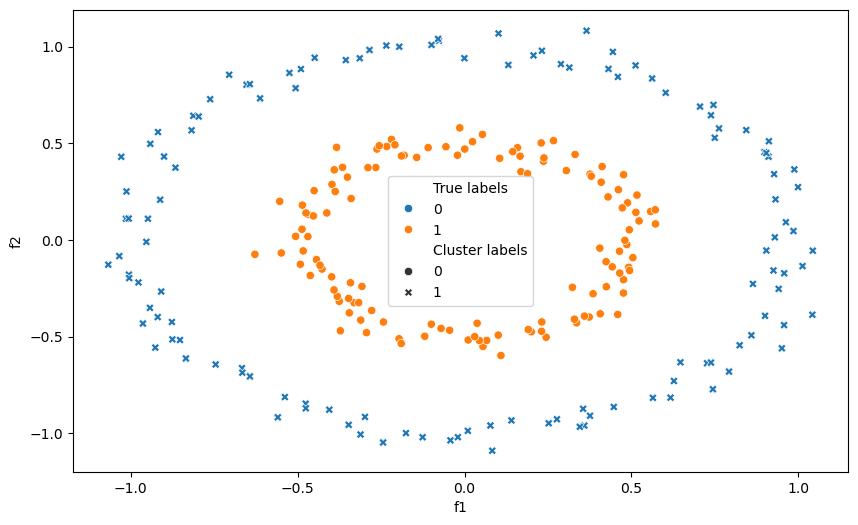

In [73]:
fig, ax = plt.subplots(figsize=(10, 6))

with warnings.catch_warnings():
    warnings.filterwarnings(
        "ignore",
        message="Graph is not fully connected, spectral embedding"
        + " may not work as expected.",
        category=UserWarning,
    )
    model = cluster.SpectralClustering(n_clusters=2, affinity="nearest_neighbors")
    part = model.fit_predict(X)

true_labels = pd.Series(data_labels).astype("category").rename("True labels")
cluster_labels = pd.Series(part).astype("category").rename("Cluster labels")

ax = sns.scatterplot(
    data,
    x="f1",
    y="f2",
    hue=true_labels,
    style=cluster_labels,
)

# ax.scatter(
#     model.cluster_centers_[:, 0],
#     model.cluster_centers_[:, 1],
#     marker="D",
#     color="red",
#     s=100,
# )

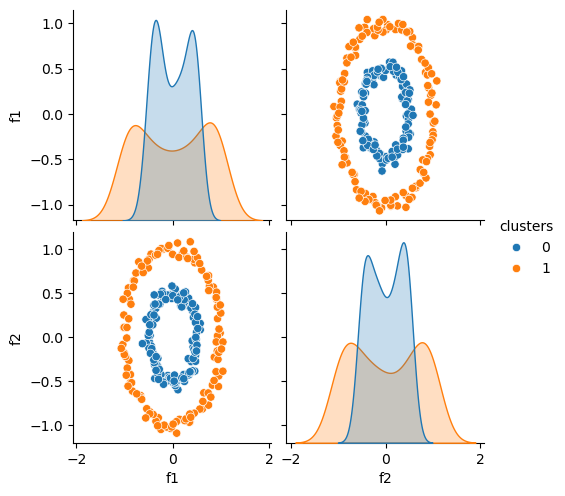

In [74]:
sns.pairplot(data.assign(clusters=cluster_labels), hue="clusters")

_Answer_: The two features are important.

### DBSCAN

#### Question 3

In [75]:
X = data.to_numpy()

np.random.seed(0)

Ks = np.linspace(0.20, 0.50, 10)

perf_ari = {}
perf_nmi = {}
for k in Ks:
    model = cluster.DBSCAN(eps=k)
    # model = cluster.OPTICS(max_eps=k)
    part = model.fit_predict(X).astype(float)
    assert (
        part[part < 0].shape[0] == 0
    ), "DBSCAN return noisy points; try other parameters"

    perf_ari[k] = ari(part, data_labels)
    perf_nmi[k] = nmi(part, data_labels)

In [76]:
_tmp = pd.DataFrame(
    {
        "ari": perf_ari,
        "nmi": perf_nmi,
    },
    index=Ks,
)
display(_tmp.sort_values("ari"))

ari  nmi
0.433333  0.0  0.0
0.400000  0.0  0.0
0.366667  0.0  0.0
0.333333  0.0  0.0
0.500000  0.0  0.0
0.466667  0.0  0.0
0.300000  1.0  1.0
0.266667  1.0  1.0
0.200000  1.0  1.0
0.233333  1.0  1.0

In [77]:
_tmp.corr()

ari  nmi
ari  1.0  1.0
nmi  1.0  1.0

_Answer_:
1. NA (stability analysis here is not possible, at least in the same way we are doing it)
2. $eps=0.233$ and other similar values, with perfect agreement with the true labels.
3. NA.

#### Question 4

In [78]:
perf_s = {}
perf_c = {}
perf_d = {}
for k in Ks:
    model = cluster.DBSCAN(eps=k)
    part = model.fit_predict(X)
    if len(np.unique(part)) > 1:
        perf_s[k] = silhouette_score(X, part)
        perf_c[k] = calinski_harabasz_score(X, part)
        perf_d[k] = davies_bouldin_score(X, part)

In [79]:
_tmp = pd.DataFrame(
    {
        "Silhouette": perf_s,
        "CH": perf_c,
        "DB": perf_d,
    },
    index=Ks,
)
display(_tmp.sort_values("Silhouette"))

Silhouette        CH          DB
0.200000    0.109704  0.010231  147.481256
0.233333    0.109704  0.010231  147.481256
0.266667    0.109704  0.010231  147.481256
0.300000    0.109704  0.010231  147.481256
0.333333         NaN       NaN         NaN
0.366667         NaN       NaN         NaN
0.400000         NaN       NaN         NaN
0.433333         NaN       NaN         NaN
0.466667         NaN       NaN         NaN
0.500000         NaN       NaN         NaN

In [80]:
_tmp.dropna().corr()

Silhouette  CH  DB
Silhouette         NaN NaN NaN
CH                 NaN NaN NaN
DB                 NaN NaN NaN

_Answer_:
1. All values are very low.
2. NA (DBSCAN here returns always the same partition for different values of `eps`)

#### Question 5

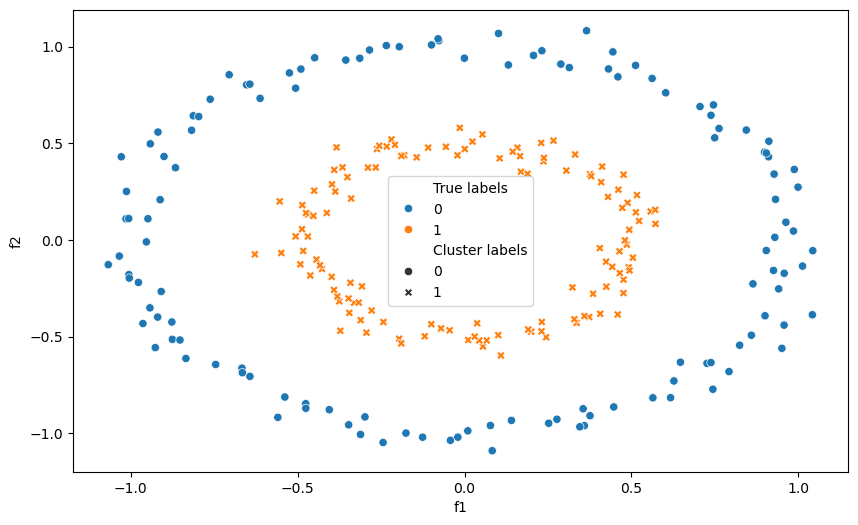

In [81]:
fig, ax = plt.subplots(figsize=(10, 6))

model = cluster.DBSCAN(eps=0.300000)
part = model.fit_predict(X)

true_labels = pd.Series(data_labels).astype("category").rename("True labels")
cluster_labels = pd.Series(part).astype("category").rename("Cluster labels")

ax = sns.scatterplot(
    data,
    x="f1",
    y="f2",
    hue=true_labels,
    style=cluster_labels,
)

# ax.scatter(
#     model.cluster_centers_[:, 0],
#     model.cluster_centers_[:, 1],
#     marker="D",
#     color="red",
#     s=100,
# )

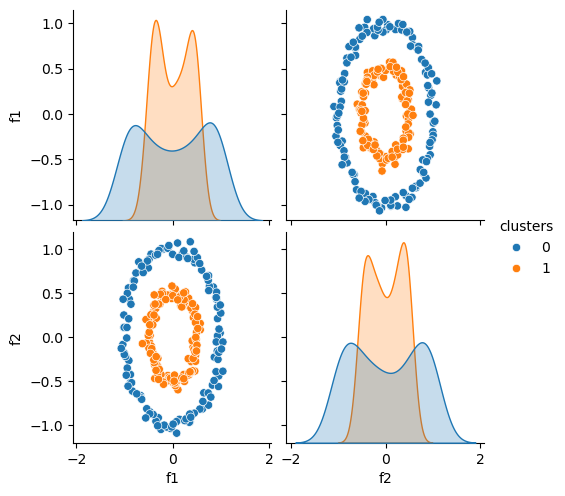

In [82]:
sns.pairplot(data.assign(clusters=cluster_labels), hue="clusters")

_Answer_: The two features are important.

### Hierarchical Clustering

#### Question 3

Text(0, 0.5, 'Stability Score')

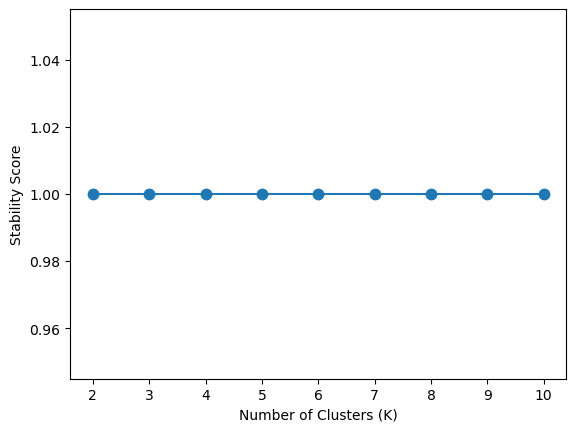

In [83]:
X = data.to_numpy()

np.random.seed(0)

Ks = range(2, 11)
n_reps = 10
cluster_labels = []
pairwise_ari = []
# centroid_positions = {}
stability_scores = []

for k in Ks:
    labels = []
    centroids = []

    for _ in range(n_reps):
        model = cluster.AgglomerativeClustering(n_clusters=k, linkage="single")
        labels.append(model.fit_predict(X))
        # centroids.append(model.cluster_centers_)

    cluster_labels.append(labels)
    # centroid_positions[k] = centroids

    # Compute pairwise adjusted Rand index (ARI) for stability
    ari_distances = pdist(labels, metric=ari)
    pairwise_ari.append(ari_distances)
    stability_scores.append(ari_distances.mean())

plt.plot(Ks, stability_scores, marker=".", linestyle="-", markersize=15)
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Stability Score")

**IMPORTANT**: Stability here does not make sense because the algorithm always returns the same partition given a $K$.

In [84]:
perf_ari = {}
perf_nmi = {}
for k in Ks:
    model = cluster.AgglomerativeClustering(n_clusters=k, linkage="single")
    part = model.fit_predict(X)
    perf_ari[k] = ari(part, data_labels)
    perf_nmi[k] = nmi(part, data_labels)

In [85]:
_tmp = pd.DataFrame(
    {
        "ari": perf_ari,
        "nmi": perf_nmi,
    },
    index=Ks,
)
display(_tmp)

ari       nmi
2   1.000000  1.000000
3   0.992032  0.983472
4   0.837707  0.838506
5   0.686025  0.722436
6   0.625713  0.664069
7   0.623458  0.658305
8   0.613596  0.637982
9   0.591936  0.609904
10  0.574915  0.587383

In [86]:
_tmp.corr()

ari       nmi
ari  1.000000  0.997494
nmi  0.997494  1.000000

_Answer_:
1. NA
2. $K=2$, with perfect agreement with the true labels. $K=3$ is also very close to perfect matching.
3. NA

#### Question 4

In [87]:
perf_s = {}
perf_c = {}
perf_d = {}
for k in Ks:
    model = cluster.AgglomerativeClustering(n_clusters=k, linkage="single")
    part = model.fit_predict(X)
    perf_s[k] = silhouette_score(X, part)
    perf_c[k] = calinski_harabasz_score(X, part)
    perf_d[k] = davies_bouldin_score(X, part)

In [88]:
_tmp = pd.DataFrame(
    {
        "Silhouette": perf_s,
        "CH": perf_c,
        "DB": perf_d,
    },
    index=Ks,
)
display(_tmp.sort_values("Silhouette"))

Silhouette         CH          DB
3    -0.009740   0.916303   69.035639
4    -0.000266  17.537930    3.936552
5     0.072355  56.168769    1.490905
9     0.086232  71.913916    0.772074
8     0.109008  66.821556    0.822472
10    0.109077  75.024372    0.742762
2     0.109704   0.010231  147.481256
7     0.120221  73.370451    0.872446
6     0.133684  87.140563    0.924786

In [89]:
_tmp.corr()

Silhouette        CH        DB
Silhouette    1.000000  0.687662 -0.106580
CH            0.687662  1.000000 -0.771076
DB           -0.106580 -0.771076  1.000000

_Answer_:
1. No, internal metrics of clustering quality do not match with solutions with the highest accuracy.
2. A little bit between Silhouette and CH, but not with DB.

#### Question 5

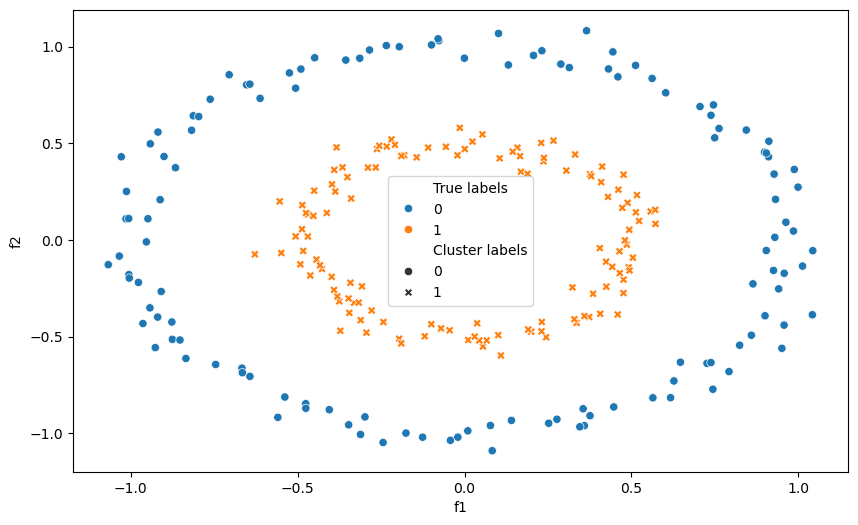

In [90]:
fig, ax = plt.subplots(figsize=(10, 6))

model = cluster.AgglomerativeClustering(n_clusters=2, linkage="single")
part = model.fit_predict(X)

true_labels = pd.Series(data_labels).astype("category").rename("True labels")
cluster_labels = pd.Series(part).astype("category").rename("Cluster labels")

ax = sns.scatterplot(
    data,
    x="f1",
    y="f2",
    hue=true_labels,
    style=cluster_labels,
)

# ax.scatter(
#     model.cluster_centers_[:, 0],
#     model.cluster_centers_[:, 1],
#     marker="D",
#     color="red",
#     s=100,
# )

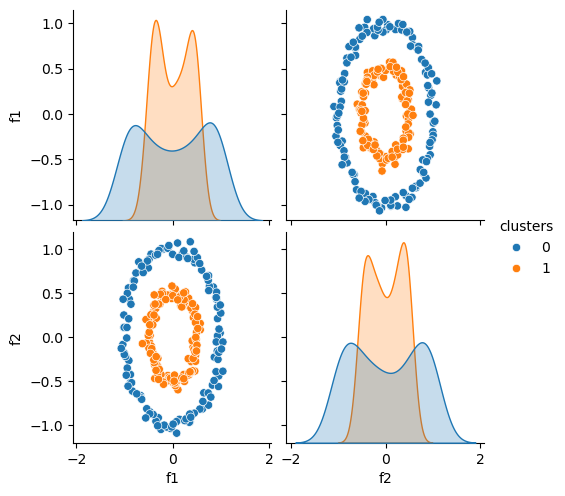

In [91]:
sns.pairplot(data.assign(clusters=cluster_labels), hue="clusters")

_Answer_: The two features are important.